<a href="https://colab.research.google.com/github/JamilePolycarpo/RedesNeurais-Imagem3D/blob/main/ImagemRedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install kaggle
 #caso seja necessário atualizar a biblioteca no google colab

from google.colab import files
files.upload() #enviar o arquivo kaggle.json

#antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle competitions download -c image-matching-challenge-2022
#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/buckingham_palace/images/42572558_3847795752.jpg  
  inflating: train/buckingham_palace/images/43210627_10009473243.jpg  
  inflating: train/buckingham_palace/images/43583354_7506898338.jpg  
  inflating: train/buckingham_palace/images/43641758_9015255137.jpg  
  inflating: train/buckingham_palace/images/43728242_3176119914.jpg  
  inflating: train/buckingham_palace/images/43847879_5656257946.jpg  
  inflating: train/buckingham_palace/images/44446238_9117834424.jpg  
  inflating: train/buckingham_palace/images/44573130_5715131949.jpg  
  inflating: train/buckingham_palace/images/44579495_1325305773.jpg  
  inflating: train/buckingham_palace/images/44944081_6780023064.jpg  
  inflating: train/buckingham_palace/images/45136306_6779959250.jpg  
  inflating: train/buckingham_palace/images/45439163_5667030438.jpg  
  inflating: train/buckingham_palace/images/45955845_8872058158.jpg  
  inflating: train/buckingham_

In [ ]:
import os
import shutil
import random
from PIL import Image
import cv2
import imghdr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing import image

#
source_dir = "/content/train"
target_dir = "/content/test_images"

# Definindo a quantidade de fotos em cada
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Criando as pastas de validacao, treino e teste
train_dir = os.path.join(target_dir, "treino")
val_dir = os.path.join(target_dir, "validacao")
test_dir = os.path.join(target_dir, "teste")

# Create the directories for train, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each subdirectory in the source directory
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name, "images")

    if os.path.isdir(folder_path):
        #lista de todas as pastas
        images = os.listdir(folder_path)

        # Dividindo as imagens entre as pastas
        num_images = len(images)
        num_train = int(num_images * train_ratio)
        num_val = int(num_images * val_ratio)
        num_test = int(num_images * test_ratio)

        # Criando as subpastas
        train_class_dir = os.path.join(train_dir, folder_name)
        val_class_dir = os.path.join(val_dir, folder_name)
        test_class_dir = os.path.join(test_dir, folder_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        print(val_class_dir)


        # Movendo as imagens para a pasta correspondente
        for i in range(num_images):
            image_path = os.path.join(folder_path, images[i])
            if os.path.isfile(image_path):
                if i < num_train:
                    shutil.move(image_path, train_class_dir)
                elif i < num_train + num_val:
                    shutil.move(image_path, val_class_dir)
                else:
                    shutil.move(image_path, test_class_dir)


/content/test_images/validacao/brandenburg_gate
/content/test_images/validacao/british_museum
/content/test_images/validacao/notre_dame_front_facade
/content/test_images/validacao/colosseum_exterior
/content/test_images/validacao/piazza_san_marco
/content/test_images/validacao/buckingham_palace
/content/test_images/validacao/pantheon_exterior
/content/test_images/validacao/trevi_fountain
/content/test_images/validacao/st_peters_square
/content/test_images/validacao/st_pauls_cathedral
/content/test_images/validacao/sagrada_familia
/content/test_images/validacao/lincoln_memorial_statue
/content/test_images/validacao/grand_place_brussels
/content/test_images/validacao/sacre_coeur
/content/test_images/validacao/taj_mahal
/content/test_images/validacao/temple_nara_japan


In [ ]:
import cv2
import imghdr

#removendo fotos com extensões não compativeis


image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(target_dir):#percorrendo todas as pastas
  if os.path.isdir(image_class):
   for image in os.listdir(os.path.join(target_dir, image_class)): #percorrendo todas as fotos de todas as pastas
     image_path = os.path.join(target_dir,image_class,image)

     try:
       img = cv2.imread(image_path)
       tip = imghdr.what(image_path)
       if tip not in image_exts:
         print("Imagem não está na extensao certa{}".format(image_path))
         os.remove(image_path)
     except Exception as e:
       print("Problema com a imagem{}".format(image_path))



/content


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory('/content/test_images/treino', batch_size=32)
validation_dataset = image_dataset_from_directory('/content/test_images/validacao',batch_size=32)

test_dataset = image_dataset_from_directory('/content/test_images/teste',batch_size=32)


Found 3966 files belonging to 16 classes.
Found 1130 files belonging to 16 classes.
Found 582 files belonging to 16 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data", data_batch.shape)
  print("label", labels_batch.shape)
  print(data_batch[0].shape)

data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 3)
label (32,)
(256, 256, 3)
data (32, 256, 256, 

In [ ]:
import tensorflow as tf
data = tf.keras.utils.image_dataset_from_directory('/content/test_images/treino', batch_size = 64)
data_iterator = data.as_numpy_iterator()
batch_train = data_iterator.next()
batch_train[0].shape
batch_train[1]

data1 = tf.keras.utils.image_dataset_from_directory('/content/test_images/validacao')
data_iterator1 = data1.as_numpy_iterator()
batch_val = data_iterator1.next()
batch_val[0].shape
batch_val[1]


Found 3966 files belonging to 16 classes.
Found 1130 files belonging to 16 classes.


array([ 7,  4, 13,  6,  2, 14,  4,  2, 13, 15,  6,  9,  3, 13,  5,  6, 12,
        1,  9, 10,  6, 13,  3,  6,  9,  2,  6, 15,  0, 14,  4,  6],
      dtype=int32)

In [ ]:
batch_val[2]

NameError: name 'batch_train' is not defined

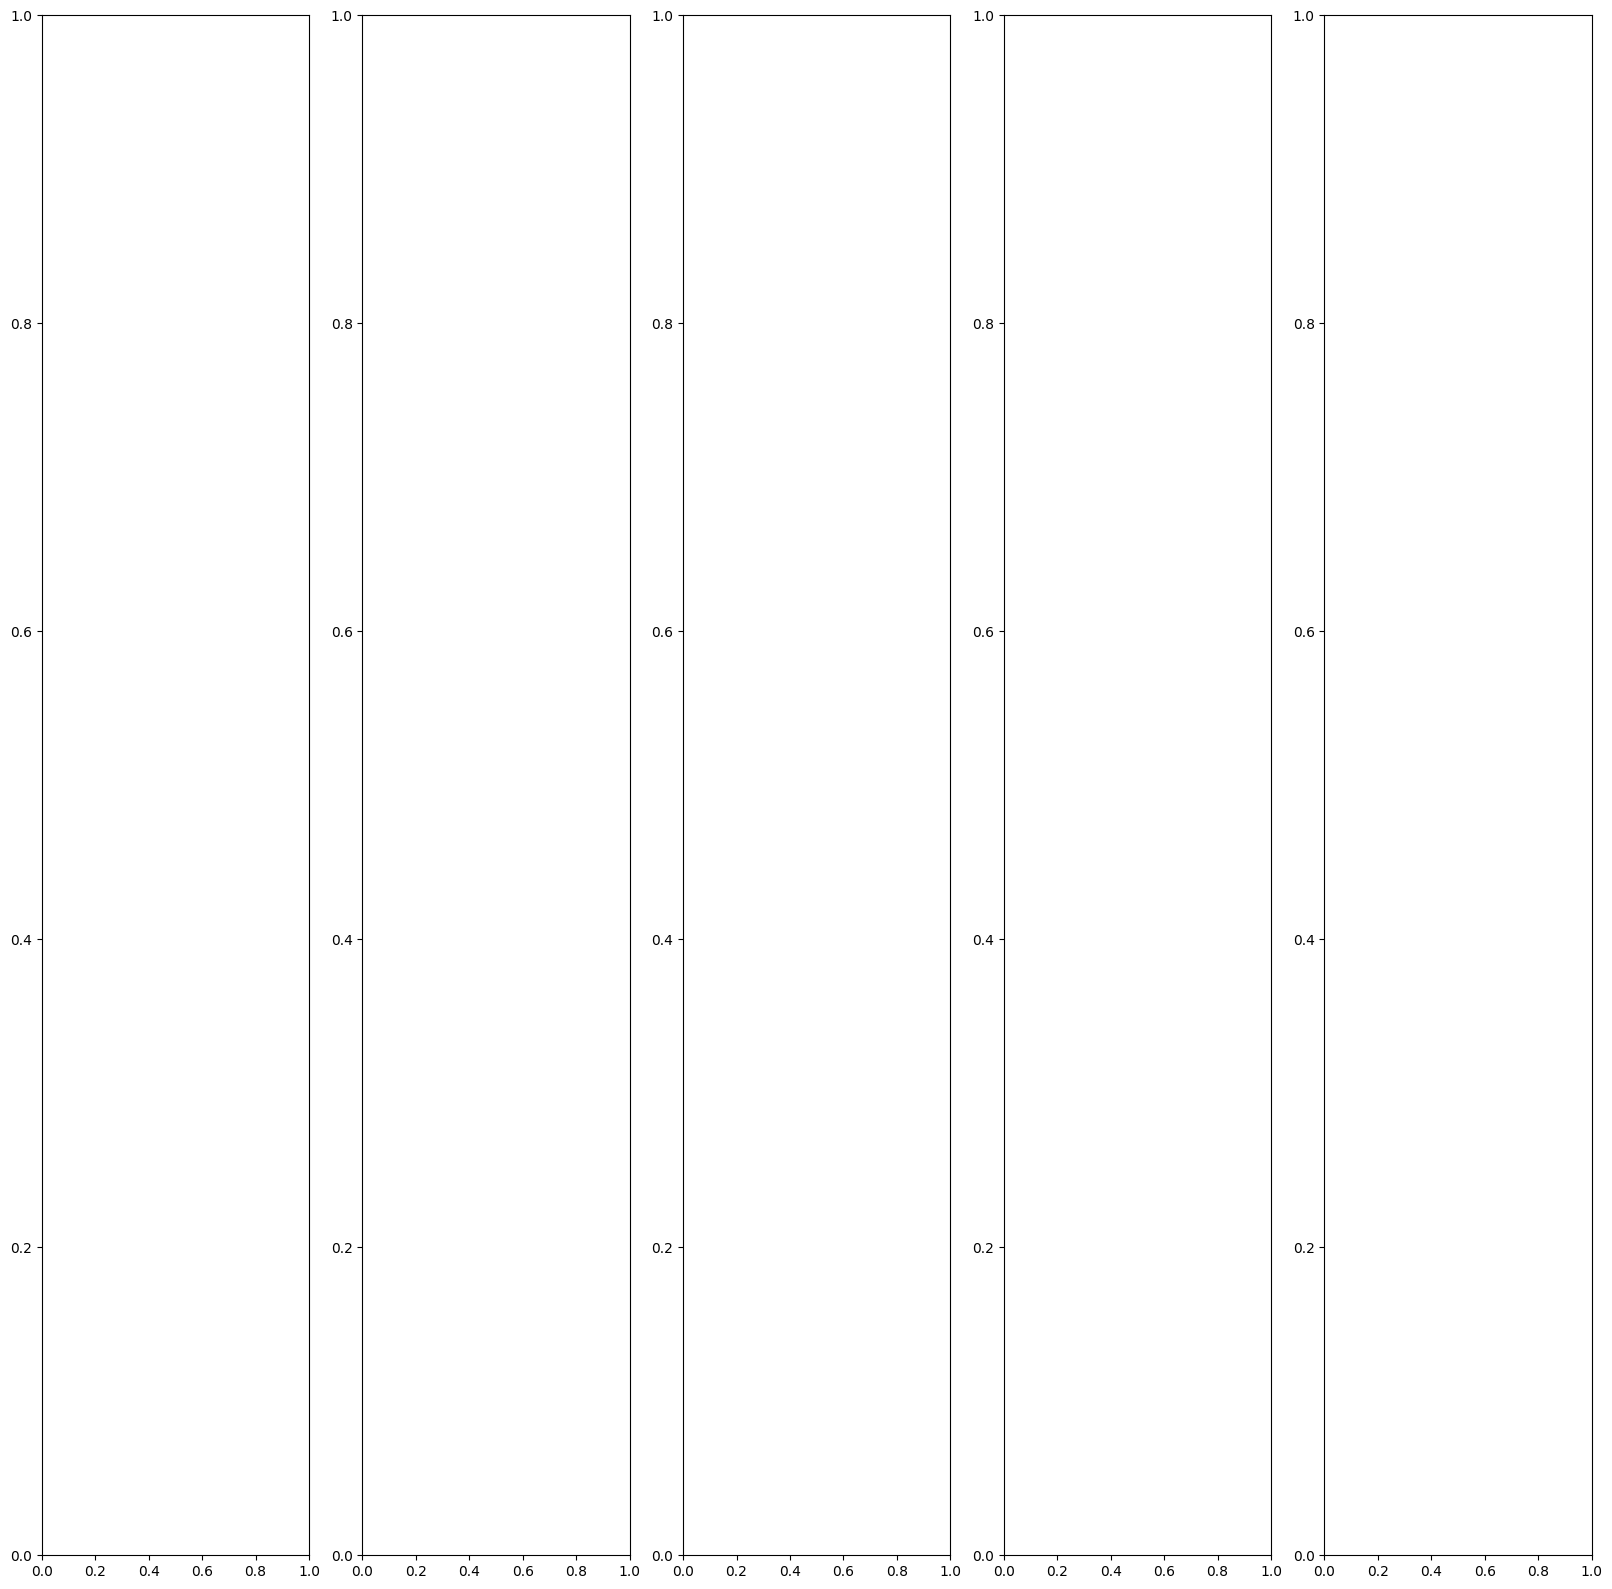

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=5, figsize=(20,20)) #checando numero das categorias com as imagens
for idx, img in enumerate(batch_train[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch_train[1][idx])




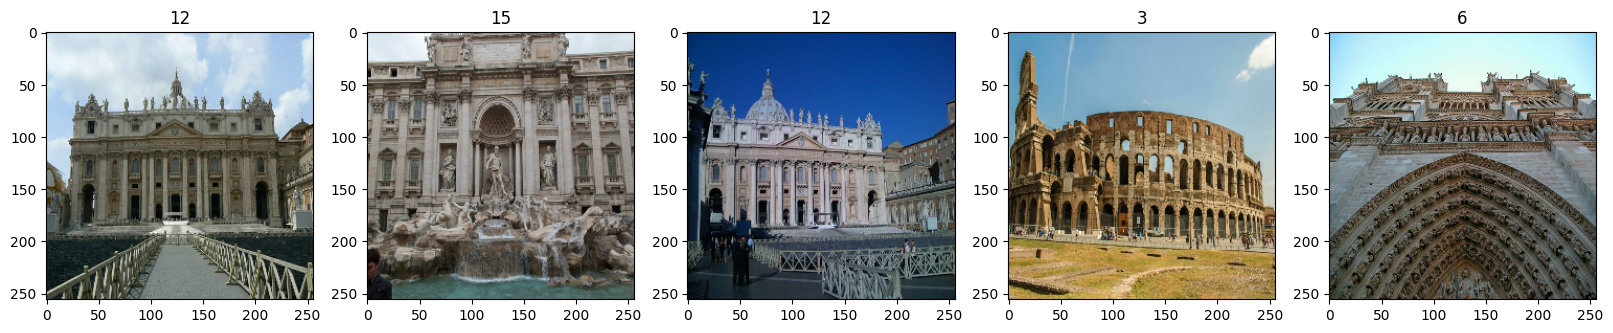

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch_val[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch_val[1][idx])

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = keras.Sequential()

model.add(Rescaling(scale=1.0/255))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
#Treino

from tensorflow.keras.callbacks import ModelCheckpoint


hist = model.fit(train_dataset, epochs=20, batch_size = 32,validation_data=validation_dataset)




Epoch 1/20
124/124 [==============================] - 988s 8s/step - loss: 3.5498 - accuracy: 0.2456 - val_loss: 14.5612 - val_accuracy: 0.1044
Epoch 2/20
124/124 [==============================] - 1047s 8s/step - loss: 2.6077 - accuracy: 0.2927 - val_loss: 5.9825 - val_accuracy: 0.2142
Epoch 3/20
124/124 [==============================] - 986s 8s/step - loss: 2.5185 - accuracy: 0.3016 - val_loss: 4.3790 - val_accuracy: 0.2673
Epoch 4/20
 56/124 [============>.................] - ETA: 8:23 - loss: 2.4658 - accuracy: 0.3025

In [ ]:
val


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from matplotlib import pyplot as plt
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(1, len (accuracy) + 1)
plt.plot(epochs, accuracy, "p", label="Treino acc")
plt.plot(epochs, val_accuracy, "b", label="Val acc")
plt.xlabel ("Épocas")
plt.ylabel ("%s")
plt.title("Acurácia de Treino e falidação")
plt.legend( )
plt.figure()
plt.plot(epochs, loss, "r", label="Treino loss")
plt.plot(epochs, val_loss, "b", label="Val loss")
plt.xlabel ("Épocas")
plt.ylabel ("%s")
plt.title("Loss de Treino e Validação")
plt.legend()
plt.show()


NameError: name 'hist' is not defined

In [ ]:
from keras.preprocessing import image
import numpy as np

#teste com alguma imagem para ver se reconhece

test_img = image.load_img("download.jpg", target_size=(256,256))
x = image.array_to_img(test_img)
x = np.expand_dims(x, axis=0)
pred=model.predict(x)
label = np.argmax(prediction[0])

print(label)

FileNotFoundError: [Errno 2] No such file or directory: 'download.jpg'